In [1]:
import os
import cv2
import random
import datetime
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score

from src.utils.utils_generate_samples import generate_pairs, generate_shape_image
from src.models.CoAttentionModel import CoAttentionModel

# Analysis

**Test dataset** was formed with 20,000 pairs of images containing different shapes and 20,000 pairs with identical images (10,000 per shape).

On the test set, the model achieved:

- Precision: 0.9963084904719146
- Recall: 0.9986
- Accuracy: 0.99745
- F1 Score: 0.9974529291314987
- ROC AUC: 1

The model makes a few minor errors:

- On images with small shapes near the boundary, where transformations cause imprecise object shapes.
- Some errors occur on large/small shapes, which was expected during training due to a strong imbalance in shape sizes.

Improvements:

- Create a balanced dataset for each shape size, which should help eliminate these errors.

### Model

In [15]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print('cuda is available!!!!')
elif not torch.cuda.is_available():
    print('cuda not available! Training initialized on cpu ...')
    device=torch.device("cpu")

cuda is available!!!!


In [3]:
class CoAttentionModelClass(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()
        self.device = device
        self.model = CoAttentionModel()

        self.load_weights(weights_path)
        
    
    def load_weights(self, weights_path):
        self.model.load_state_dict(torch.load(weights_path, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()

    def forward(self, img1, img2):
        
        out = self.model(img1.to(self.device), img2.to(self.device))
        prob = torch.sigmoid(out)    
        return prob
        

In [4]:
weights_path = 'data/2025_02_24T022_43_10/weight.epoch_27_loss_val_0.0032797735447304384.pth'
model = CoAttentionModelClass(weights_path=weights_path, device=device)


### Generate test samples

In [5]:
df = pd.read_csv('data/train_val_test_split.csv')
df = df[df['split'] == 'test']
df = df.reset_index()

In [18]:
### Generate pairs
seed = 42

df_circle = df[df['shape'] == 'circle']
df_square = df[df['shape'] == 'square']  

### Generate pairs
pairs_circle_square = generate_pairs(df_circle, df_square, size=20_000, seed=seed)
pairs_circle_circle = generate_pairs(df_circle, df_circle, size=10_000, seed=seed)
pairs_square_square = generate_pairs(df_square, df_square, size=10_000, seed=seed)

PAIRS = pairs_circle_square + pairs_circle_circle + pairs_square_square

### Run model on test samples

In [19]:
def get_sample(index):
        
    shape = df.at[index, 'shape']
    size = df.at[index, 'size']
    x = df.at[index, 'x']
    y = df.at[index, 'y']
    angle = df.at[index, 'angle']

    return generate_shape_image(shape=shape, s=size, position=(x, y), angle=angle)

In [57]:
df_res = pd.DataFrame(columns=['index1', 'index2', 'target', 'prob'])

for pair in tqdm(PAIRS):
    img1, shape1 = get_sample(pair[0])
    img2, shape2 = get_sample(pair[1])
    
    img1 = torch.from_numpy(np.array(img1, dtype=np.float32)).unsqueeze(0).unsqueeze(0) / 255.
    img2 = torch.from_numpy(np.array(img2, dtype=np.float32)).unsqueeze(0).unsqueeze(0) / 255.

    prob = model(img1, img2)

    target = 1 if shape1 == shape2 else 0

    df_res.loc[df_res.shape[0]] = [pair[0], pair[1], target,  prob.item()]

100%|██████████| 40000/40000 [02:59<00:00, 222.75it/s]


### Analysis

In [45]:
y_true = df_res['target'].values
y_scores = df_res['prob'].values

In [46]:
default_threshold = 0.5
y_pred_default = (y_scores >= default_threshold).astype(int)

precision = precision_score(y_true, y_pred_default)
recall = recall_score(y_true, y_pred_default)
accuracy = accuracy_score(y_true, y_pred_default)
f1 = f1_score(y_true, y_pred_default)

print("For threshold = 0.5")
print("\t- precision:", precision)
print("\t- recall:", recall)
print("\t- accuracy:", accuracy)
print("\tF1 Score:", f1)


For threshold = 0.5
	- precision: 0.9963084904719146
	- recall: 0.9986
	- accuracy: 0.99745
	F1 Score: 0.9974529291314987


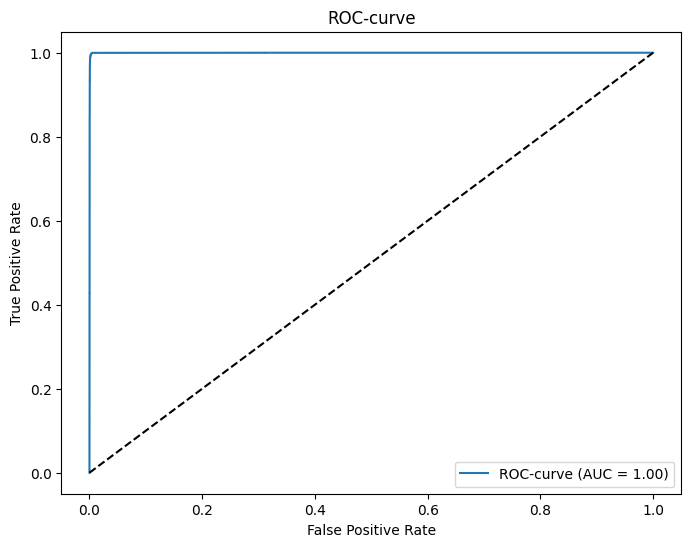

In [49]:
roc_auc = roc_auc_score(y_true, y_scores)
fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve")
plt.legend(loc="lower right")
plt.show()


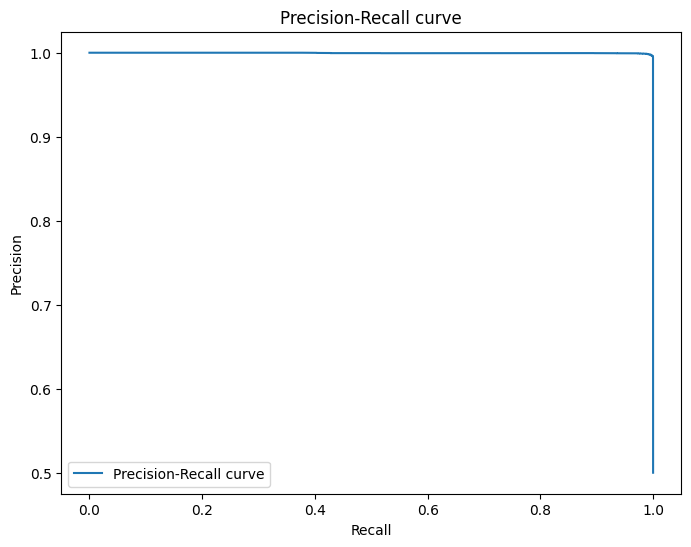

In [50]:
precisions, recalls, thresholds_pr = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="best")
plt.show()

In [51]:
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_f1 = 0
for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    current_f1 = f1_score(y_true, y_pred)
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = thresh

print("The best threshold for F1 Score:", best_threshold, "with F1 Score:", best_f1)


The best threshold for F1 Score: 0.24 with F1 Score: 0.9976541053156974


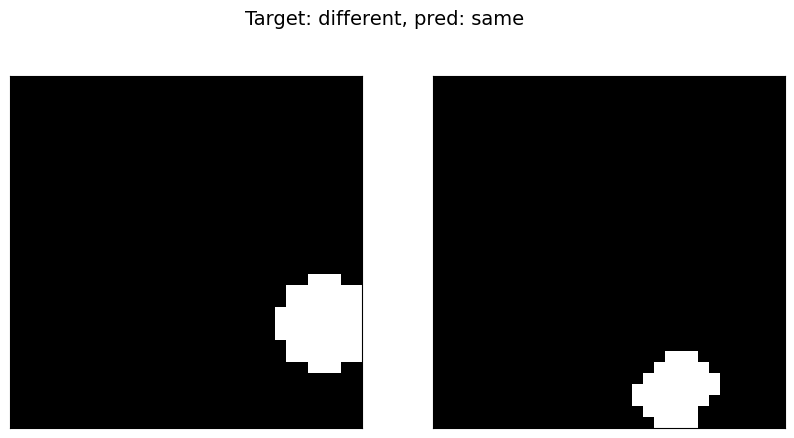

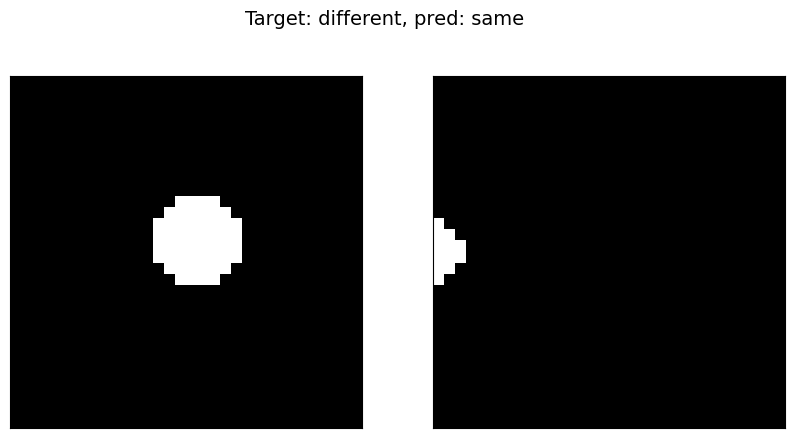

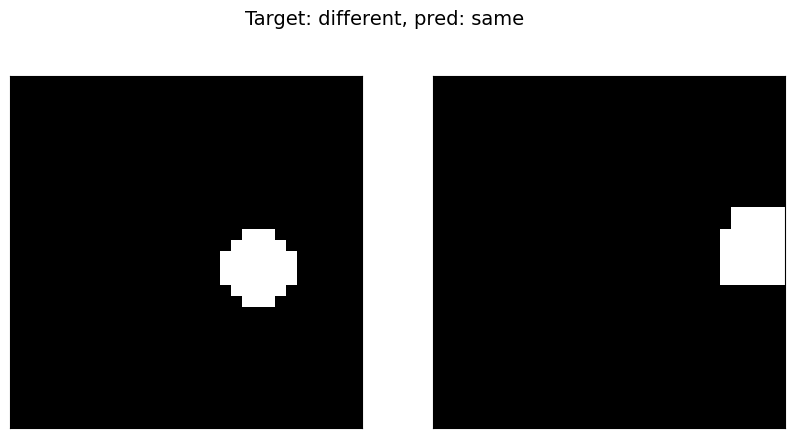

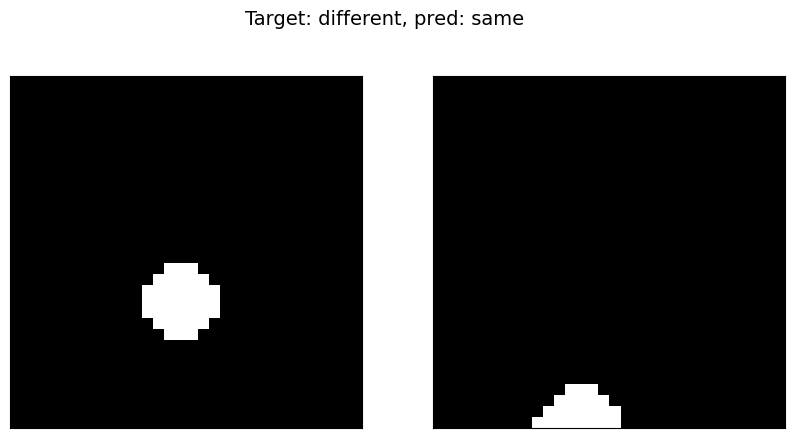

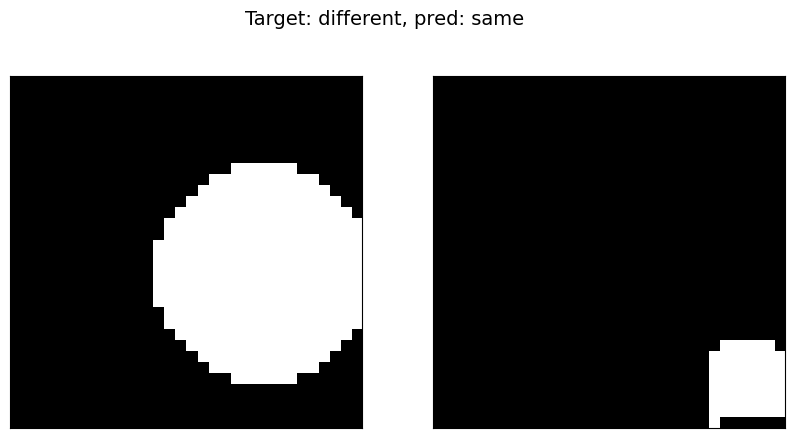

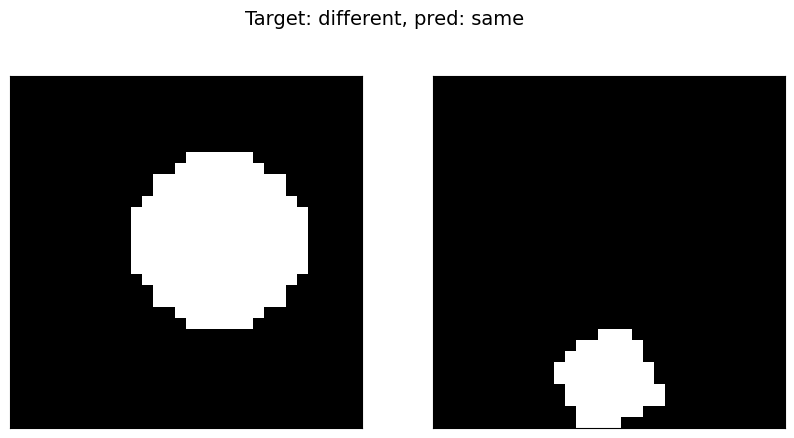

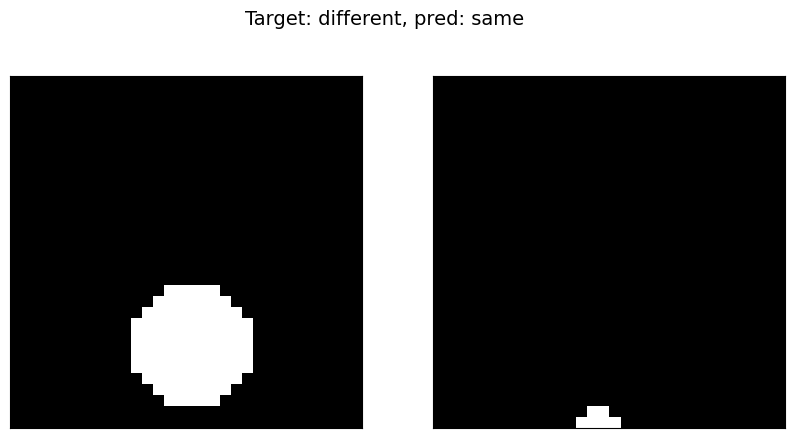

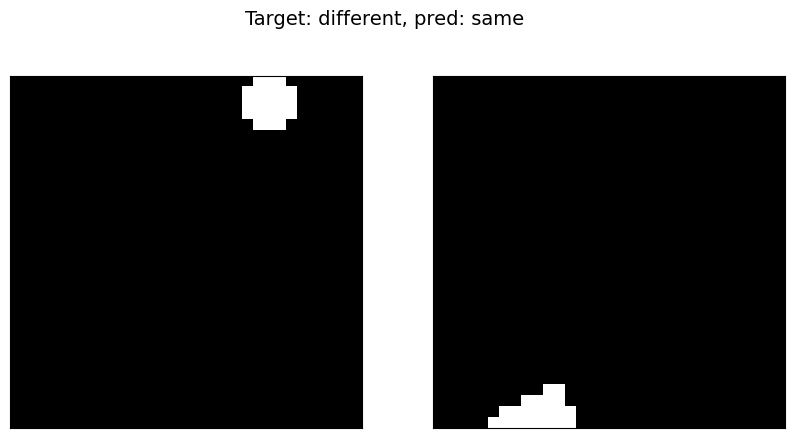

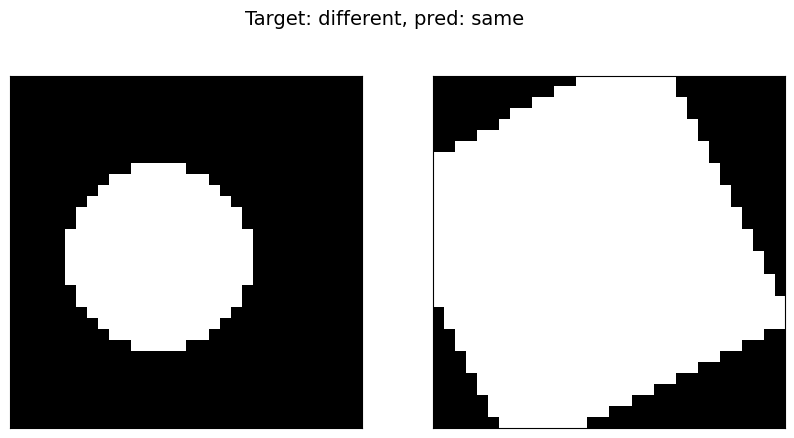

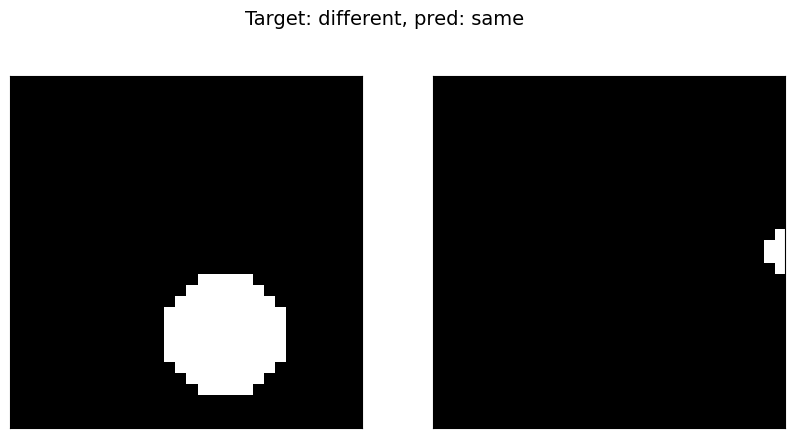

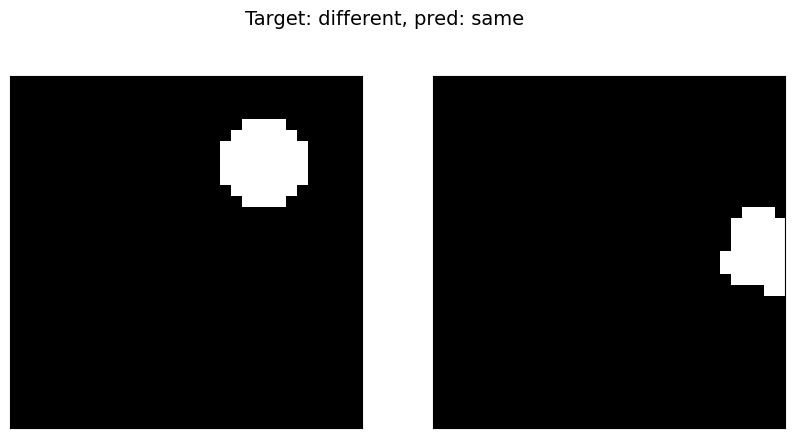

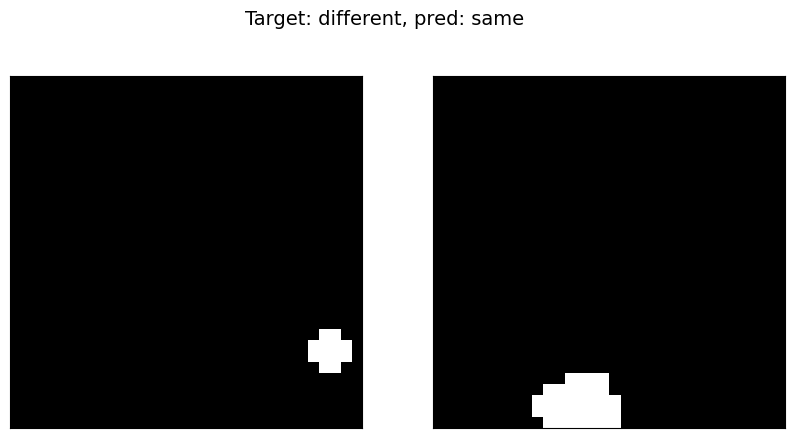

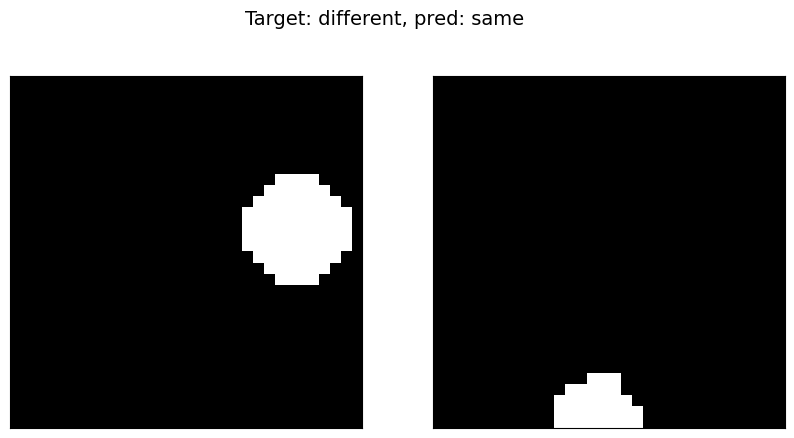

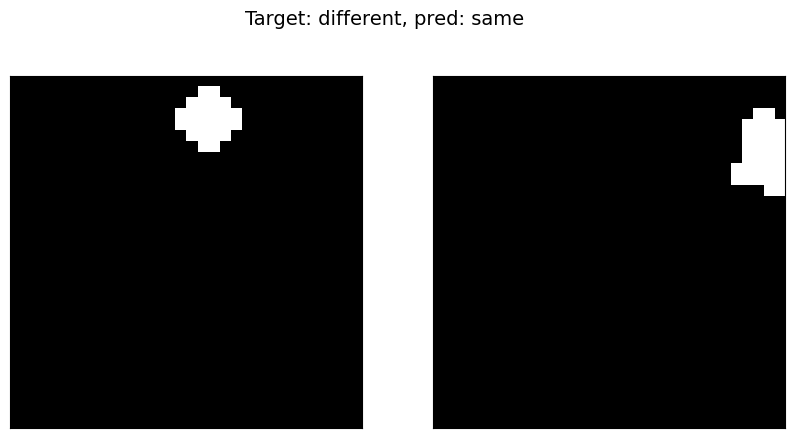

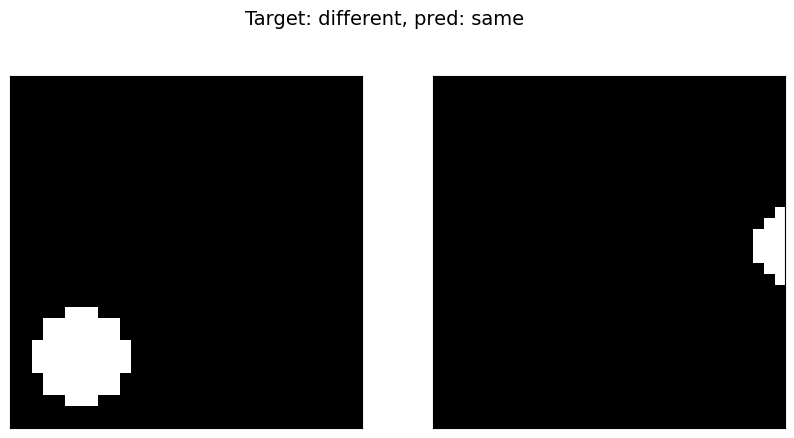

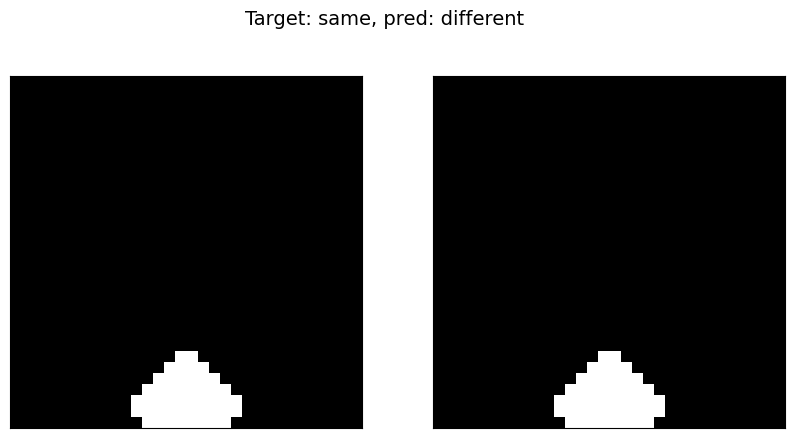

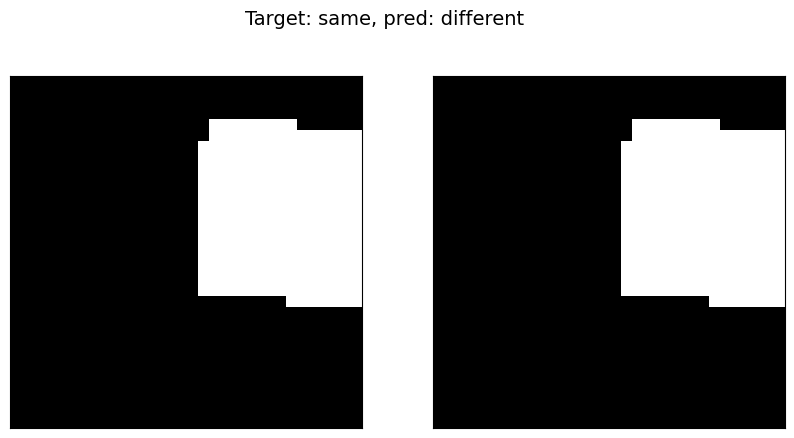

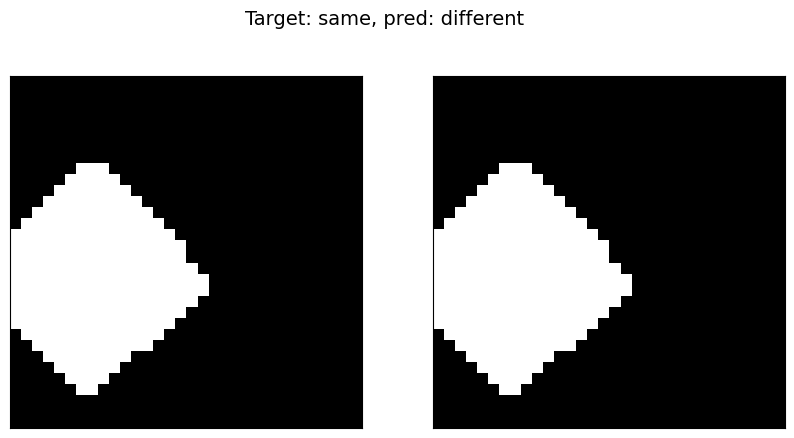

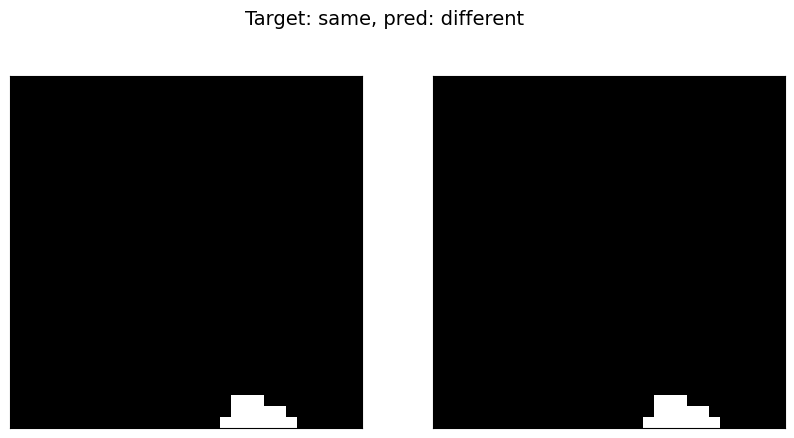

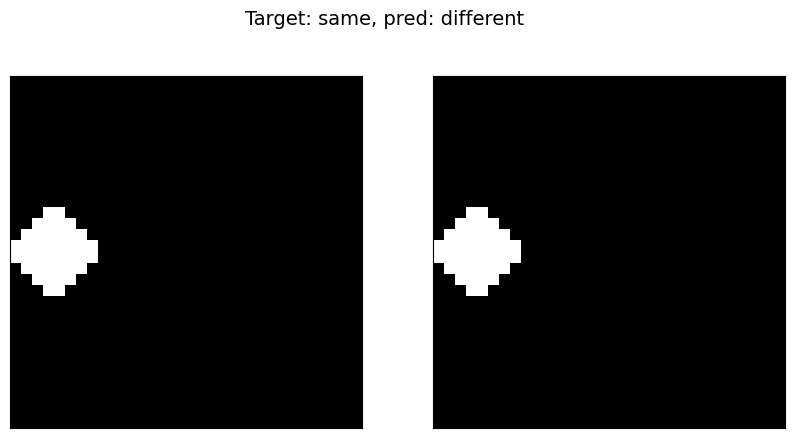

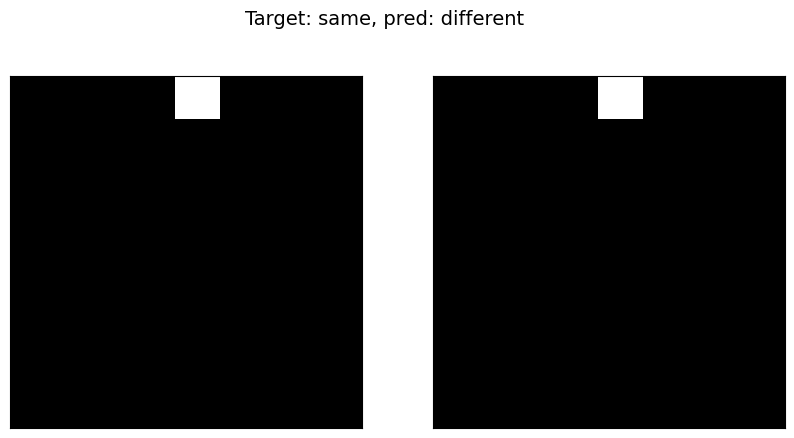

In [62]:
df_res['pred'] = df_res['prob'] > 0.5
df_error = df_res[df_res['target'] != df_res['pred']]

for i in df_error.index[::5]:
    index1 = df_error.at[i, 'index1']
    index2 = df_error.at[i, 'index2']
    target = df_error.at[i, 'target']
    pred = df_error.at[i, 'pred']

    img1, shape1 = get_sample(index1)
    img2, shape2 = get_sample(index2)


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(img1, cmap='Greys')
    axs[1].imshow(img2, cmap='Greys')

    
    target_suffix = 'same' if target == 1 else 'different'
    pred_suffix = 'same' if pred == 1 else 'different'
    suptitle = 'Target: {}, pred: {}'.format(target_suffix, pred_suffix)
    plt.suptitle(suptitle, fontsize=14)
    
    for i in range(2):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()

    